##INTRODUCTION

This project is not set out to recommend any stocks. I'm not a trader, not even close. However, it is my interest to learn more about how to read stock charts and using technical indicators and see how it compare to trade based on speculation and news (of course, these two create volatility offering short term opportunities). I learned many of the code below from Derek Banas, an Udemy instructor. I recommend anyone interested in the same topic NOT to just copy the code. It helps to type out all the code, google/stackoverflow anything you don't understand, and most importantly, google the concept behind ichimoku cloud, moving average, etc.  Once you have a more than a basic understanding of the concept and the code, try to use the code to build your own portfolio and use the ichimoku cloud to test few trades. The data I used is a 5 year data, but it's good idea to run a 6 month and 1 year analysis to compare/analyze with the 5 year analysis. I didn't do it here so this notebook will be super long!
<br>
<br>

I only scratched the surface and there are so much more to learn! I will be continuing to learn more, create a Tableau visulization on the EDA, and building up this project 😃.
<br>
<br>

The data is from yfinance and https://www.nasdaq.com/market-activity/stocks/screener
<br>
<br>
The code is seperated into 3 parts:

1.  EDA on NYSE and NASDAQ

2.  Downloading Stock Data and Building the Ichimoku Cloud.

3.  Finding a Optimal Portfolio with Sharpe Ratio.





**Sidenote:** Due to the amount of time it required to download all the stocks from NASDAQ, I only picked the top 200 based on market cap. Of course, you can run on all of the NASDAQ tickers if you would like. 

**Import libraries**

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import time
import os
import seaborn as sns

**Obtain Stock Data from Yahoo Finance**

In [119]:
pip install yfinance

In [120]:
import yfinance as yf

**Set Start and End Date**

In [121]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

**Getting the CSV on Some Tickers**

In [122]:
tickers = ['AMZN', 'COST', 'ADBE', 'QQQ', 'NVDA', 'VUG', 'VGT', 'VOO', 'SPY', 'ARKK', 'ADBE','NVDA', 'AMD', 'MSFT', 'DIS', 'WMT', 'TGT', 'HD']

for ticker in tickers:
  stock = yf.Ticker(ticker)
  df = stock.history(period="5y")
  df.sort_index(axis = 0.,  ascending=False)
  df.to_csv(ticker + '.csv')


##EDA on NASDAQ and NYSE

The goal of this notebook is to code the ichimoku cloud and finding a optimal portfolio based on cumulative returns. We run a EDA on the dataset, but may not impute or change or fill in some of the missing values. 

Data source: https://www.nasdaq.com/market-activity/stocks/screener

In [135]:
nasdaq = pd.read_csv("/content/Nasdaq.csv")
nasdaq.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services


In [126]:
nasdaq.shape

(8414, 11)

In [127]:
nasdaq.dtypes

#IPO Year is in float64, most likely due to NaN values. 

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

**2021 has the most IPO**

Text(0, 0.5, 'IPO Year')

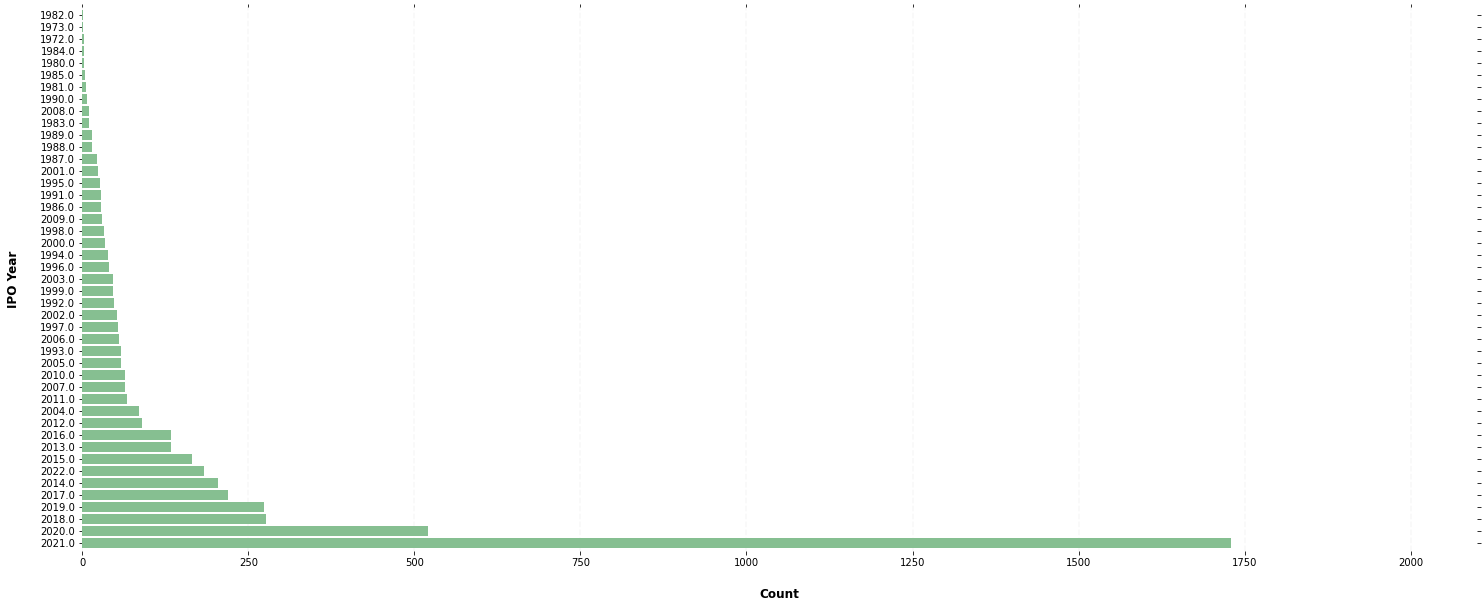

In [193]:
ipo_year = nasdaq['IPO Year'].value_counts().sort_values(ascending=False)
ax = ipo_year.plot(kind='barh', figsize=(25, 10), color='#86bf91', zorder=2, width=0.85)

#Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
     ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Count", labelpad=20, weight='bold', size=12)
ax.set_ylabel("IPO Year", labelpad=20, weight='bold', size=12)

 

**Companies that IPO in 2021**

In [192]:
nasdaq.loc[nasdaq['IPO Year'] == 2021]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
198,RIVN,Rivian Automotive Inc. Class A Common Stock,$66.29,3.6400,5.81%,5.968204e+10,United States,2021.0,16233384,Capital Goods,Auto Manufacturing
278,RBLX,Roblox Corporation Class A Common Stock,$73.30,4.9800,7.29%,4.242865e+10,NaN,2021.0,46987587,Technology,EDP Services
281,NU,Nu Holdings Ltd. Class A Ordinary Shares,$9.15,0.4700,5.42%,4.216946e+10,NaN,2021.0,7163441,NaN,NaN
290,CPNG,Coupang Inc. Class A Common Stock,$23.68,0.8200,3.59%,4.147413e+10,NaN,2021.0,4971754,Capital Goods,Recreational Products/Toys
375,FERG,Ferguson plc Ordinary Shares,$150.73,2.6500,1.79%,3.303508e+10,NaN,2021.0,49061,Consumer Durables,Industrial Machinery/Components
...,...,...,...,...,...,...,...,...,...,...,...
7942,ZWRKU,Z-Work Acquisition Corp. Units,$9.86,-0.0195,-0.20%,0.000000e+00,United States,2021.0,509,NaN,NaN
7943,ZWRKW,Z-Work Acquisition Corp. Warrant,$0.42,0.0200,5.00%,0.000000e+00,United States,2021.0,32686,NaN,NaN
8244,NRGV,Energy Vault Holdings Inc. Common Stock,$9.93,0.5400,5.75%,NaN,NaN,2021.0,364179,NaN,NaN
8341,SOND,Sonder Holdings Inc. Class A Common Stock,$7.28,-0.5700,-7.26%,NaN,United States,2021.0,667243,NaN,NaN


In [179]:
# Missing values

percent_missing = nasdaq.isnull().sum() * 100 / len(nasdaq)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,40.373188
Sector,26.194438
Industry,26.016164
Country,9.424768
Market Cap,5.585928
% Change,0.071310
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000


In [180]:
# Duplicate values
percentage = nasdaq.duplicated(keep=False).value_counts(normalize=True) * 100
percentage

False    100.0
dtype: float64

In [181]:
nasdaq.describe()

,Net Change,Market Cap,IPO Year,Volume
count,8414.000000,7.944000e+03,5017.000000,8.414000e+03
mean,0.858206,8.048253e+09,2014.940403,1.006303e+06
std,17.360950,6.181705e+10,8.940584,4.450063e+06
min,-86.160000,0.000000e+00,1972.000000,1.000000e+00
25%,0.000000,5.564069e+07,2013.000000,1.488175e+04
50%,0.110000,3.724824e+08,2019.000000,1.103035e+05
75%,0.560000,2.265847e+09,2021.000000,5.547030e+05
max,1570.000000,3.000000e+12,2022.000000,1.795731e+08


**Checking to see which company has the IPO year 1972 as that's the earliest year for IPO**

In [184]:
nasdaq.loc[nasdaq['IPO Year'] == 1972]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
88,AMAT,Applied Materials Inc. Common Stock,$139.84,7.98,6.05%,1.240000e+11,United States,1972.0,8755811,Capital Goods,Industrial Machinery/Components
1221,COKE,Coca-Cola Consolidated Inc. Common Stock,$577.16,-11.84,-2.01%,5.410118e+09,United States,1972.0,19761,Consumer Non-Durables,Beverages (Production/Distribution)



**Checking to see which company has the most market cap**

In [186]:
nasdaq.loc[nasdaq['Market Cap'] == 3.000000e+12]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing


**Checking to see which company has the max net change**

In [187]:
nasdaq.loc[nasdaq['Net Change'] == 1570]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
8033,BRK/A,Berkshire Hathaway Inc.,"$473,980.00",1570.0,0.33%,NaN,United States,NaN,1502,NaN,NaN


**Checking to see which company has least net change**

In [185]:
nasdaq.loc[nasdaq['Net Change'] == -86.16]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
1419,SEB,Seaboard Corporation Common Stock,"$3,709.99",-86.16,-2.27%,4.306478e+09,United States,1996.0,1148,NaN,NaN


In [188]:
nasdaq.columns

Index(['Symbol', 'Name', 'Last Sale', 'Net Change', '% Change', 'Market Cap',
       'Country', 'IPO Year', 'Volume', 'Sector', 'Industry'],
      dtype='object')

In [189]:
#print(nasdaq['Sector'].value_counts())
print(nasdaq['Sector'].value_counts(normalize=True)*100)

Finance                  26.586151
Health Care              18.550725
Technology               13.558776
Consumer Services        12.061192
Capital Goods             7.697262
Consumer Non-Durables     3.768116
Energy                    3.510467
Public Utilities          3.446055
Basic Industries          3.317230
Miscellaneous             3.011272
Consumer Durables         2.560386
Transportation            1.932367
Name: Sector, dtype: float64


Rows, Columns: (8414, 11)


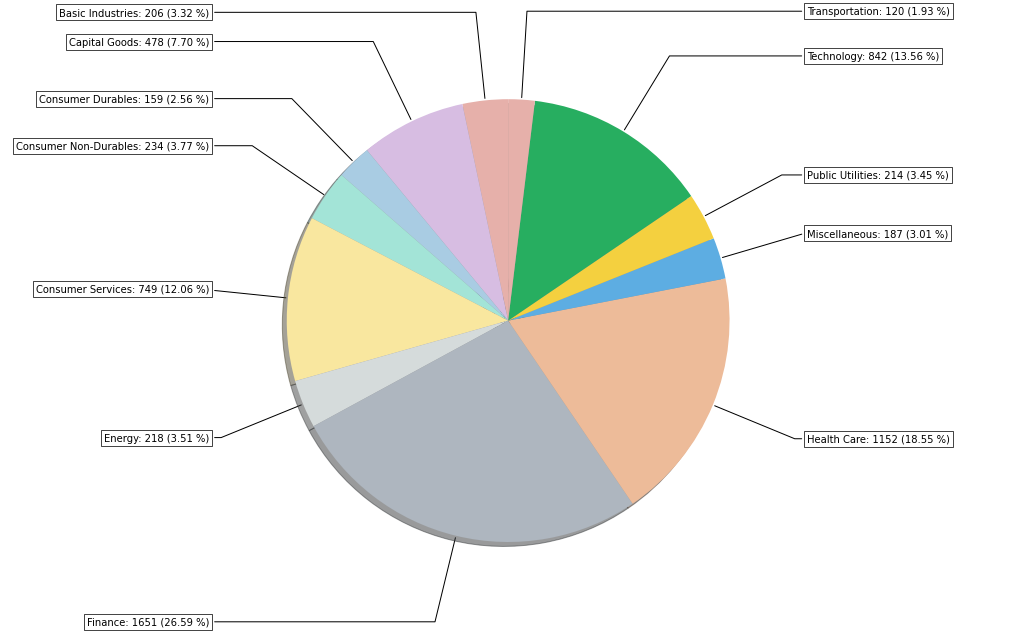

In [190]:
print("Rows, Columns:",nasdaq.shape)
Sector = nasdaq.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [194]:
nasdaq['Industry'].groupby(nasdaq['Sector']).value_counts()


Sector            Industry                
Basic Industries  Major Chemicals             32
                  Precious Metals             31
                  Steel/Iron Ore              28
                  Industrial Specialties      27
                  Agricultural Chemicals      12
                                              ..
Transportation    Railroads                    5
                  Hotels/Resorts               2
                  Advertising                  1
                  Rental/Leasing Companies     1
                  Transportation Services      1
Name: Industry, Length: 223, dtype: int64

In [195]:
country = nasdaq['Country'].value_counts()
country[0:21] 

United States     6308
China              230
Canada             228
Israel             118
United Kingdom      99
Bermuda             70
Cayman Islands      62
Hong Kong           49
Greece              34
Brazil              32
Switzerland         30
Netherlands         28
Singapore           27
Germany             24
Mexico              23
Ireland             22
France              17
Australia           16
Argentina           16
Luxembourg          15
Malaysia            12
Name: Country, dtype: int64

**EDA on NYSE. Shorter than NASDAQ**

In [198]:
nyse = pd.read_csv("/content/NYSE.csv")
nyse.head(3)

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$135.91,0.70,0.52%,4.082276e+10,United States,1999.0,2368248,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$74.04,0.18,0.24%,1.363075e+10,NaN,2016.0,6819279,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.75,0.01,0.10%,1.218750e+09,NaN,2021.0,88047,Finance,Business Services


In [197]:
nyse.shape

(3183, 11)

In [199]:
# Missing values

percent_missing = nyse.isnull().sum() * 100 / len(nyse)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,46.685517
Sector,26.453032
Industry,26.264530
Country,22.965756
Market Cap,14.043355
Ticker,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000
% Change,0.000000


In [200]:
nyse.describe()

,Net Change,Market Cap,IPO Year,Volume
count,3183.000000,2.736000e+03,1697.000000,3.183000e+03
mean,1.273917,1.327673e+10,2012.660577,1.377164e+06
std,27.965390,4.004990e+10,9.131653,4.984651e+06
min,-31.990000,0.000000e+00,1986.000000,1.000000e+00
25%,0.002800,4.018503e+08,2007.000000,3.711650e+04
50%,0.180000,1.755592e+09,2016.000000,2.349100e+05
75%,0.775000,7.984638e+09,2020.000000,9.886290e+05
max,1570.000000,6.457610e+11,2022.000000,1.811841e+08


In [201]:
#print(nyse['Sector'].value_counts())
print(nyse['Sector'].value_counts(normalize=True)*100)

Finance                  30.499786
Consumer Services        16.275096
Technology                9.611277
Capital Goods             9.568560
Public Utilities          6.236651
Energy                    5.980350
Basic Industries          5.425032
Health Care               5.168731
Consumer Non-Durables     4.186245
Miscellaneous             2.819308
Transportation            2.648441
Consumer Durables         1.580521
Name: Sector, dtype: float64


Rows, Columns: (3183, 11)


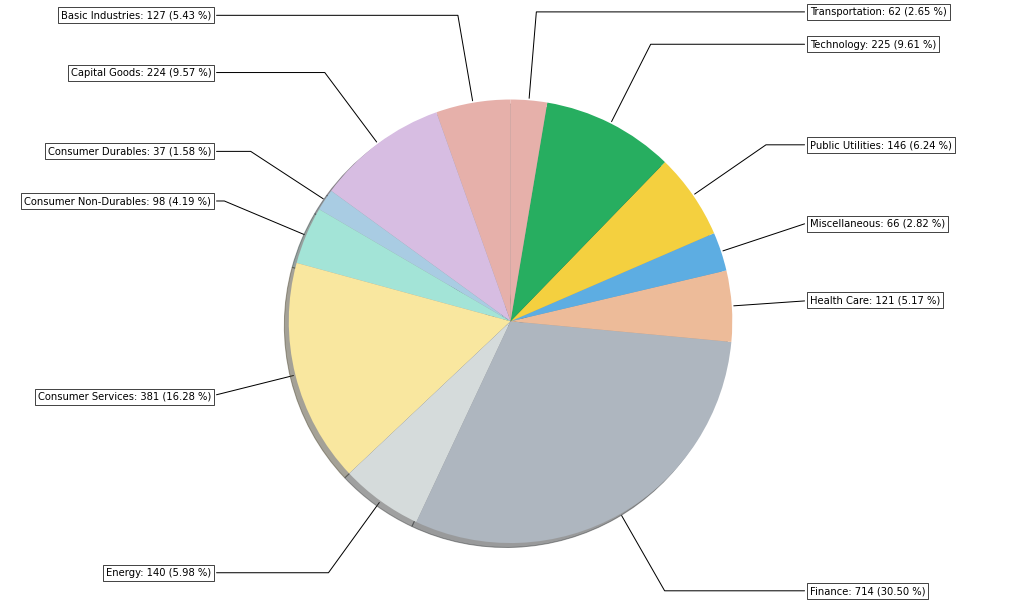

In [202]:
print("Rows, Columns:",nyse.shape)
Sector = nyse.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [203]:
country = nyse['Country'].value_counts()
country[0:21] 

United States     2063
Canada              71
Bermuda             49
China               36
United Kingdom      28
Brazil              20
Greece              16
Switzerland         13
Netherlands         11
Monaco              10
Mexico              10
Argentina           10
Cayman Islands       9
Japan                9
Chile                8
South Korea          8
Ireland              8
India                8
Luxembourg           8
South Africa         6
Singapore            4
Name: Country, dtype: int64

**Downloading the Tickers from NASDAQ.csv**

In [204]:
def get_column_from_csv(file, col_name):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

In [205]:
tickers = get_column_from_csv("/content/Nasdaq.csv", "Symbol")
print(len(tickers))
tickers

8414


0         AAPL
1         MSFT
2        GOOGL
3         GOOG
4         AMZN
         ...  
8409     WRB^G
8410     WRB^H
8411     WSO/B
8412    XFLT^A
8413    YCBD^A
Name: Symbol, Length: 8414, dtype: object

In [206]:
def save_to_csv_from_yahoo(folder, ticker):
    stock = yf.Ticker(ticker)
    
    try:
        print("Get Data for : ", ticker)
        # Get historical closing price data
        df = stock.history(period="5y")
    
        # Wait 2 seconds
        time.sleep(2)
        
        # Remove the period for saving the file name
        # Save data to a CSV file
        # File to save to 
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't Get Data for :", ticker)

In [207]:
PATH = "/content/"

*Due to the amount of tickers and the run time required for the code. I ran the top 199 tickers only in the NASDAQ base on market cap.*

In [208]:
for x in range(0, 300):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished")

Get Data for :  AAPL
/content/AAPL.csv  Saved
Finished
Get Data for :  MSFT
/content/MSFT.csv  Saved
Finished
Get Data for :  GOOGL
/content/GOOGL.csv  Saved
Finished
Get Data for :  GOOG
/content/GOOG.csv  Saved
Finished
Get Data for :  AMZN
/content/AMZN.csv  Saved
Finished
Get Data for :  TSLA
/content/TSLA.csv  Saved
Finished
Get Data for :  NVDA
/content/NVDA.csv  Saved
Finished
Get Data for :  TSM
/content/TSM.csv  Saved
Finished
Get Data for :  FB
/content/FB.csv  Saved
Finished
Get Data for :  V
/content/V.csv  Saved
Finished
Get Data for :  JPM
/content/JPM.csv  Saved
Finished
Get Data for :  UNH
/content/UNH.csv  Saved
Finished
Get Data for :  JNJ
/content/JNJ.csv  Saved
Finished
Get Data for :  BAC
/content/BAC.csv  Saved
Finished
Get Data for :  PG
/content/PG.csv  Saved
Finished
Get Data for :  MA
/content/MA.csv  Saved
Finished
Get Data for :  WMT
/content/WMT.csv  Saved
Finished
Get Data for :  HD
/content/HD.csv  Saved
Finished
Get Data for :  BABA
/content/BABA.csv  Sa

In [209]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [210]:
get_stock_df_from_csv('COST')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-17,156.828329,157.748902,155.943500,157.176895,2424400,0.0,0
2017-02-21,157.793600,158.195790,157.302028,158.142166,2317000,0.0,0
2017-02-22,158.258330,158.276196,156.470808,157.757812,1815200,0.0,0
2017-02-23,157.766711,158.231457,156.595886,157.167892,2599900,0.0,0
2017-02-24,156.604875,158.830346,156.515494,158.696274,1684300,0.0,0
...,...,...,...,...,...,...,...
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0
2022-02-14,508.989990,511.529999,501.440002,506.559998,1720300,0.0,0
2022-02-15,513.340027,516.000000,510.760010,513.919983,1984600,0.0,0


In [211]:
from os import listdir
from os.path import isfile, join

files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
len(tickers)

308

In [212]:
def add_daily_return_to_df(df):
  df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
  return df

In [213]:
def add_cum_return_to_df(df):
  df['cum_return'] = (1 + df['daily_return']).cumprod()
  return df

In [214]:
def add_bollinger_bands(df):
  df['middle_band'] = df['Close'].rolling(window=20).mean()
  df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
  df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
  return df

In [215]:
def add_ichimoku(df):
  #Conversion line
  hi_val = df['High'].rolling(window=9).max()
  lo_val = df['Low'].rolling(window=9).min()
  df['Conversion'] = (hi_val+lo_val)/2

  #Base Line
  hi_val2 = df['High'].rolling(window=26).max()
  lo_val2 = df['Low'].rolling(window=26).min()
  df['Baseline'] = (hi_val2+lo_val2)/2

  #Span A
  df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

  #Span B
  hi_val3 = df['High'].rolling(window=52).max()
  lo_val3 = df['Low'].rolling(window=52).min()
  df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

  #Laggine Span
  df['Lagging'] = df['Close'].shift(-26)
  return df



##What is the Ichimoku Cloud?

Ichimoku is a technical indicator. The 5 lines of the cloud are:

1. Tenkan Sen = Conversion Line: determine the direction of the short-term trend (yellow). Faster line. 
2. Kijun Sen = Base Line: avg for medium point and shows mid-term trend (red). Slower line.
3. Senkou Span A = Leading Span A (green)
4. Senkou Span B = Leading Span B (red)
5. Chikou Line = Lagging Span (teal): helps to confirm signal.


Few important concepts:
1. Formed between Span A and Span B, the **cloud** shows support and resistance.
2. Span A and Span B are set 26 periods into the future.  
3. Chikou represents the closing price and set 26 periods in the past. 
4. Wider the cloud, the stronger the trend. 
5. Try to not use the strategy for less than 1 hour. 


Reading the cloud:
1. Price is above the cloud: UP trend. Green color. Top of cloud is the support. 
2. Price is below the cloud: DOWN trend. Red color. Bottom of cloud is the resistant. 
3. Not recommended to trade when price is inside the cloud. Market is not trending. Use top of cloud as resistance and bottom as support. 
4. Tk/Golden Cross: when conversion past base from bottom to up, a **BUY** signal. If the price is above the cloud during this cross, it is a strong buy signal. If the price is below the cloud, you may want to wait until price is on top of the cloud. If the lagging span is crossing the price at the same time at the same direction, it's also another signal on buy. Set the stop loss at the narest local minimum.
5. Death Cross: when conversion past base from top to bottom, a **SELL** signal. If the price is below the cloud during this cross, it is a strong sell signal. If the price is above the cloud, you may want to wait until price is on bottom of the cloud before entering short positions. Set the stop loss at the narest local maximum.

Strategy Visualization: [ichimoku](https://yukiphotostudio.pixieset.com/ichimoku/)

In [225]:
for x in tickers:
  try:
    print("Working on:", x)
    new_df = get_stock_df_from_csv(x)
    new_df = add_daily_return_to_df(new_df)
    new_df = add_cum_return_to_df(new_df)
    new_df = add_bollinger_bands(new_df)
    new_df = add_ichimoku(new_df)
    new_df.to_csv(PATH + x + '.csv')
  except Exception as ex:
    print(ex)

Working on: ABB
Working on: DUK
Working on: AMD
Working on: ETN
Working on: MRNA
Working on: ENB
Working on: FCX
Working on: GE
Working on: ACN
Working on: NGG
Working on: TSM
Working on: LMT
Working on: CRWD
Working on: UL
Working on: JCI
Working on: MCO
Working on: CNC
Working on: TD
Working on: EL
Working on: MO
Working on: JNJ
Working on: CM
Working on: UBER
Working on: MMC
Working on: KO
Working on: WM
Working on: CVX
Working on: DHR
Working on: DD
Working on: CRM
Working on: APH
Working on: FDX
Working on: HSBC
Working on: AZN
Working on: COF
Working on: CCI
Working on: MCHP
Working on: SONY
Working on: WBA
Working on: NVO
Working on: RIO
Working on: SQ
Working on: V
Working on: AFL
Working on: SPGI
Working on: SNY
Working on: PEP
Working on: SCHW
Working on: MNST
Working on: LFC
Working on: PM
Working on: WFC
Working on: CI
Working on: BAC
Working on: ORLY
Working on: UPS
Working on: EQNR
Working on: LLY
Working on: MELI
Working on: TFC
Working on: JD
Working on: QCOM
Working on

**Testing on Costco stock**

In [226]:
df = pd.read_csv('/content/COST.csv', index_col=0)

#daily return
df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1

#cumulative return
df['cum_return'] = (1 + df['daily_return']).cumprod()

#moving average 20 days
df['middle_band'] = df['Close'].rolling(window=20).mean()
df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

#Conversion line
hi_val = df['High'].rolling(window=9).max()
lo_val = df['Low'].rolling(window=9).min()
df['Conversion'] = (hi_val+lo_val)/2

#Base Line
hi_val2 = df['High'].rolling(window=26).max()
lo_val2 = df['Low'].rolling(window=26).min()
df['Baseline'] = (hi_val2+lo_val2)/2

#Span A
df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

#Span B
hi_val3 = df['High'].rolling(window=52).max()
lo_val3 = df['Low'].rolling(window=52).min()
df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

#Laggine Span
df['Lagging'] = df['Close'].shift(-26)

#return df
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return,cum_return,middle_band,upper_band,lower_band,Conversion,Baseline,SpanA,SpanB,Lagging
Date,,,,,,,,,,,,,,,,,
2017-02-17,156.828329,157.748902,155.943500,157.176895,2424400,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.052612
2017-02-21,157.793600,158.195790,157.302028,158.142166,2317000,0.0,0,0.006141,1.006141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.642471
2017-02-22,158.258330,158.276196,156.470808,157.757812,1815200,0.0,0,-0.002430,1.003696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.053589
2017-02-23,157.766711,158.231457,156.595886,157.167892,2599900,0.0,0,-0.003739,0.999943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.874832
2017-02-24,156.604875,158.830346,156.515494,158.696274,1684300,0.0,0,0.009725,1.009667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.989990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0,-0.016992,3.242652,501.585789,535.411614,467.759965,515.213971,510.491300,512.852636,523.849531,NaN
2022-02-14,508.989990,511.529999,501.440002,506.559998,1720300,0.0,0,-0.006102,3.222866,501.802350,535.698012,467.906688,517.839996,507.920163,512.880080,524.313070,NaN
2022-02-15,513.340027,516.000000,510.760010,513.919983,1984600,0.0,0,0.014529,3.269692,503.131779,536.734125,469.529434,517.839996,501.270116,509.555056,525.175384,NaN


In [227]:
def plot_with_boll_bands(df, ticker):
  fig = go.Figure()

  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

  mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
  lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
  fig.add_trace(candle)
  fig.add_trace(upper_line)
  fig.add_trace(mid_line)
  fig.add_trace(lower_line)

  fig.update_xaxes(title='Date', rangeslider_visible=True)
  fig.update_yaxes(title='Price')

  fig.update_layout(title="Bollinger Bands", height=1200, width=1800, showlegend=True)

  fig.show()

In [228]:
import plotly.graph_objs as go

fig = go.Figure()

candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
fig.add_trace(candle)
fig.add_trace(upper_line)
fig.add_trace(mid_line)
fig.add_trace(lower_line)

fig.update_xaxes(title='Date', rangeslider_visible=True)
fig.update_yaxes(title='Price')

fig.update_layout(title="Bollinger Bands", height=800, width=1200, showlegend=True)

#fig.show()

In [229]:
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.2)'
    else:
        return 'rgba(250,0,0,0.2)'

In [283]:
def get_ichimoku(df):
  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  df1 = df.copy()
  fig = go.Figure()
  df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0) #return 1 for green, return 0 for red
  df['group'] = df['label'].ne(df['label'].shift()).cumsum()
  df = df.groupby('group')

  dfs = []
  for name, data in df:
    dfs.append(data)
  for df in dfs:
    fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

    fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))
    
  baseline = go.Scatter(x=df1.index, y=df1['Baseline'],
                        line=dict(color='red', width=3), name='Baseline')
  
  conversion = go.Scatter(x=df1.index, y=df1['Conversion'],
                          line=dict(color='gold', width=3), name='Conversion')
  
  lagging = go.Scatter(x=df1.index, y=df1['Lagging'],
                          line=dict(color='purple', width=2), name='Lagging')
  
  span_a = go.Scatter(x=df1.index, y=df1['SpanA'],
                          line=dict(color='green', width=2, dash='dot'), name='Span A')
  
  span_b = go.Scatter(x=df1.index, y=df1['SpanB'],
                          line=dict(color='red', width=2, dash='dot'), name='Span B')
  
  fig.add_trace(candle)
  fig.add_trace(baseline)
  fig.add_trace(conversion)
  fig.add_trace(lagging)
  fig.add_trace(span_a)
  fig.add_trace(span_b)

  fig.update_layout(height=800, width=1400, showlegend=True)

  fig.show()



In [285]:
ticker_wanted = get_stock_df_from_csv('TSLA')
get_ichimoku(ticker_wanted)

##Optimal Portfolio

In [234]:
#sec_df = pd.read_csv('/content/big_stock_sectors.csv')
sec_df = pd.read_csv('/content/Nasdaq.csv')

In [240]:
sec_df.rename(columns={'Symbol': 'Ticker'}, inplace=True)


In [241]:
sec_df.head()

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.51,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
4,AMZN,Amazon.com Inc. Common Stock,"$3,130.21",26.87,0.87%,1.590000e+12,United States,1997.0,2815676,Consumer Services,Catalog/Specialty Distribution


In [242]:
sec_df['Sector'].value_counts()

Finance                  1651
Health Care              1152
Technology                842
Consumer Services         749
Capital Goods             478
Consumer Non-Durables     234
Energy                    218
Public Utilities          214
Basic Industries          206
Miscellaneous             187
Consumer Durables         159
Transportation            120
Name: Sector, dtype: int64

In [243]:
finance_df = sec_df.loc[sec_df['Sector'] == "Finance"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
tech_df = sec_df.loc[sec_df['Sector'] == "Technology"]
consumer_df = sec_df.loc[sec_df['Sector'] == "Consumer Services"]
goods_df = sec_df.loc[sec_df['Sector'] == "Capital Goods"]
nondurables_df = sec_df.loc[sec_df['Sector'] == "Consumer Non-Durables"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]
public_utilities_df = sec_df.loc[sec_df['Sector'] == "Public Utilities"]
industries_df = sec_df.loc[sec_df['Sector'] == "Basic Industries"]
misc_df = sec_df.loc[sec_df['Sector'] == "Miscellaneous"]
durables_df = sec_df.loc[sec_df['Sector'] == "Consumer Durables"]
transportation_df = sec_df.loc[sec_df['Sector'] == "Transportation"]


In [244]:
tech_df

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.9100,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.4700,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.6500,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.5100,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
6,NVDA,NVIDIA Corporation Common Stock,$264.95,22.2800,9.18%,6.620000e+11,United States,1999.0,69539716,Technology,Semiconductors
...,...,...,...,...,...,...,...,...,...,...,...
7780,STRNW,Stran & Company Inc. Warrant,$0.37,0.0112,3.11%,0.000000e+00,United States,2021.0,36192,Technology,Advertising
7782,SURGW,SurgePays Inc. Warrant,$0.70,-0.0499,-6.65%,0.000000e+00,United States,NaN,7595,Technology,Computer Software: Prepackaged Software
7844,TRKAW,Troika Media Group Inc. Warrant,$0.26,0.0199,8.29%,0.000000e+00,United States,2021.0,12045,Technology,Advertising
7876,VENAW,Venus Acquisition Corporation Warrant,$0.11,-0.0357,-24.50%,0.000000e+00,United States,2021.0,2618,Technology,EDP Services


In [286]:
def get_cum_ret_for_stocks(stock_df):
    tickers = []
    cum_rets = []

    for index, row in stock_df.iterrows():
        df = get_stock_df_from_csv(row['Ticker'])
        if df is None:
            pass
        else:
            tickers.append(row['Ticker'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [287]:
finance_df = get_cum_ret_for_stocks(finance_df)
health_df = get_cum_ret_for_stocks(health_df)
tech_df = get_cum_ret_for_stocks(tech_df)
consumer_df = get_cum_ret_for_stocks(consumer_df)
goods_df = get_cum_ret_for_stocks(goods_df)
nondurables_df = get_cum_ret_for_stocks(nondurables_df)
energy_df = get_cum_ret_for_stocks(energy_df)
public_utilities_df = get_cum_ret_for_stocks(public_utilities_df)
industries_df = get_cum_ret_for_stocks(industries_df)
misc_df = get_cum_ret_for_stocks(misc_df)
durables_df = get_cum_ret_for_stocks(durables_df)
transportation_df = get_cum_ret_for_stocks(transportation_df)


**Cumulative Return Performance Per Sector**

In [251]:
print('Finance:')
print(finance_df .sort_values(by=['CUM_RET'], ascending=False).head(10))

Finance:
   Ticker   CUM_RET
12     BX  5.253729
41    NIO  3.754546
25    PGR  3.218685
6     AXP  2.635639
20    IBN  2.620126
26    AON  2.517522
3      MS  2.361084
11    AMT  2.334510
16    CME  2.287986
22    ICE  2.250899


In [248]:
print('Health:')
print(health_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Health:
   Ticker   CUM_RET
28   MRNA  7.875268
38   ALGN  4.933183
20    ZTS  3.805908
25     EW  3.592211
18   ISRG  3.536610
35   IDXX  3.495254
4     LLY  3.338648
9     DHR  3.288060
0     UNH  3.222182
5     NVO  3.217839


In [249]:
print('Tech:')
print(tech_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Tech:
   Ticker    CUM_RET
27   TEAM  10.185012
4    NVDA   9.263474
17    AMD   8.612719
28     SE   8.452645
32     SQ   7.197650
19    NOW   6.124434
48   MSCI   5.944383
29   LRCX   5.503534
7    ASML   5.403381
0    AAPL   5.286544


In [250]:
print('Consumer Services:')
print(consumer_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Consumer Services:
   Ticker   CUM_RET
19   MELI  5.168063
0    AMZN  3.679186
13    TGT  3.554401
25    CMG  3.528309
5    COST  3.282416
12    PLD  3.257939
10    LOW  3.190051
2      HD  2.738126
8    NFLX  2.724582
24    HLT  2.693127


In [252]:
print('Capital Goods:')
print(goods_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Capital Goods:
   Ticker    CUM_RET
0    TSLA  16.147766
16   KLAC   4.607078
5    AMAT   4.082783
6      DE   3.778254
27   RACE   3.508330
2     TMO   3.465741
20   LCID   2.844287
12    ETN   2.417564
22    APH   2.289356
13   STLA   2.271738


In [253]:
print('Nondurables:')
print(nondurables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Nondurables:
   Ticker   CUM_RET
8      EL  3.763146
5    SONY  3.347798
14    KDP  2.782260
2     NKE  2.657859
20    HSY  2.117395
0      PG  2.019348
7     DEO  1.950721
17   MNST  1.883796
18    SYY  1.824279
3     PEP  1.788733


In [254]:
print('Energy:')
print(energy_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Energy:
   Ticker   CUM_RET
4     COP  2.196065
6    EQNR  2.100178
14    MPC  1.862294
8     PBR  1.643003
3     TTE  1.547936
1     CVX  1.516165
13      E  1.349315
5      BP  1.296687
12    PXD  1.293443
9     EOG  1.283998


In [255]:
print('Public Utilities:')
print(public_utilities_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Public Utilities:
   Ticker   CUM_RET
2     NEE  2.681043
9      WM  2.180425
1    TMUS  1.948530
10    EXC  1.936808
5      SO  1.686466
8    AMOV  1.635288
7     AMX  1.624915
15    AEP  1.581940
4     DUK  1.539822
14    SRE  1.499948


In [256]:
#Top 10 in other sectors:

print(industries_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(misc_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(durables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(transportation_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

  Ticker   CUM_RET
5    FCX  3.031425
1    LIN  2.803327
4    SHW  2.697900
2    RIO  2.543134
7   SCCO  2.210058
0    BHP  2.137203
3   VALE  2.071946
8    NEM  2.065215
6    APD  1.912245
9    DOW  1.426410
   Ticker   CUM_RET
11   FTNT  8.293380
1      MA  3.511696
3     ACN  2.899421
12   INFO  2.738979
0       V  2.658230
4    PYPL  2.510963
5      JD  2.502512
6     BAM  2.354971
13   PAYX  2.291067
8     PDD  2.240449
  Ticker   CUM_RET
1    ABB  1.814875
0     GE  0.454034
  Ticker   CUM_RET
1    UNP  2.546379
6    NSC  2.451876
5    CSX  2.325801
0    UPS  2.280694
4    CNI  1.879716
2   BKNG  1.604605
3   ABNB  1.269159
7    FDX  1.235529


In [257]:
# For all sectors combined
sec_cumret_df = get_cum_ret_for_stocks(sec_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

In [258]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125

In [259]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers


['ABB',
 'DUK',
 'AMD',
 'ETN',
 'MRNA',
 'ENB',
 'FCX',
 'GE',
 'ACN',
 'NGG',
 'TSM',
 'LMT',
 'CRWD',
 'UL',
 'JCI',
 'MCO',
 'CNC',
 'TD',
 'EL',
 'MO',
 'JNJ',
 'CM',
 'UBER',
 'MMC',
 'KO',
 'WM',
 'CVX',
 'DHR',
 'DD',
 'CRM',
 'APH',
 'FDX',
 'HSBC',
 'AZN',
 'COF',
 'CCI',
 'MCHP',
 'SONY',
 'WBA',
 'NVO',
 'RIO',
 'SQ',
 'V',
 'AFL',
 'SPGI',
 'SNY',
 'PEP',
 'SCHW',
 'MNST',
 'LFC',
 'PM',
 'WFC',
 'CI',
 'BAC',
 'ORLY',
 'UPS',
 'EQNR',
 'LLY',
 'MELI',
 'TFC',
 'JD',
 'QCOM',
 'ILMN',
 'PXD',
 'ARKK',
 'CMG',
 'VOD',
 'SYY',
 'SPY',
 'AMGN',
 'PYPL',
 'DIS',
 'TSLA',
 'PG',
 'AMOV',
 'SMFG',
 'T',
 'CB',
 'HLT',
 'MSCI',
 'INFO',
 'FTNT',
 'ABEV',
 'KHC',
 'CTSH',
 'STLA',
 'BABA',
 'GOOGL',
 'BIDU',
 'GOOG',
 'TAK',
 'TEL',
 'ABT',
 'MSFT',
 'WDAY',
 'PSA',
 'ADI',
 'PFE',
 'DELL',
 'BTI',
 'SPG',
 'INTC',
 'PDD',
 'SAN',
 'IBN',
 'ALGN',
 'EQIX',
 'WIT',
 'C',
 'CVS',
 'ECL',
 'SYK',
 'SHOP',
 'HON',
 'MMM',
 'D',
 'NVS',
 'COP',
 'VUG',
 'SAP',
 'BA',
 'ADM',
 'NEE',
 '

In [260]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [261]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
  mult_df = pd.DataFrame()

  for x in tickers:
    df = get_stock_df_from_csv(x)
    mask = (df.index >= sdate) & (df.index <=edate)
    mult_df[x] = df.loc[mask][col_name]
  
  return mult_df

##Portfolio List

As the introduction stated, this project is not set out to recommend any stocks. I'm not a trader, not even close. Ideally, you should pick out some tickers from each sector and create a diverify portofolio. In this notebook, I just picked the top 10 based on cumulative return of the last 5 year. The top 10 may be different if you run your analysis on a 6 month, 1 year, 26 weeks, ettc etc. 

In [288]:
print('ALL sectors:')
top_10 = sec_cumret_df.sort_values(by=['CUM_RET'], ascending=False).head(20)
top_10

ALL sectors:


,Ticker,CUM_RET
5,TSLA,16.147766
96,SHOP,10.760728
138,TEAM,10.185012
6,NVDA,9.263474
72,AMD,8.612719
140,SE,8.452645
223,FTNT,8.293380
187,MRNA,7.875268
171,SQ,7.197650
92,NOW,6.124434


In [289]:
port_list = top_10['Ticker'].tolist()
port_list

['TSLA',
 'SHOP',
 'TEAM',
 'NVDA',
 'AMD',
 'SE',
 'FTNT',
 'MRNA',
 'SQ',
 'NOW',
 'MSCI',
 'LRCX',
 'ASML',
 'AAPL',
 'BX',
 'MELI',
 'ALGN',
 'MSFT',
 'LULU',
 'KLAC']

In [290]:
#5 Year Price Changes

mult_df = merge_df_by_column_name('Close', S_DATE, E_DATE, *port_list)
mult_df

,TSLA,SHOP,TEAM,NVDA,AMD,SE,FTNT,MRNA,SQ,NOW,MSCI,LRCX,ASML,AAPL,BX,MELI,ALGN,MSFT,LULU,KLAC
Date,,,,,,,,,,,,,,,,,,,,
2017-02-17,54.445999,61.520000,29.889999,26.458757,13.130000,NaN,37.459999,NaN,14.470000,92.739998,89.812523,106.024597,120.800293,32.035351,23.402424,197.968765,101.769997,60.321781,66.730003,79.931351
2017-02-21,55.478001,63.080002,30.049999,27.406267,14.000000,NaN,37.380001,NaN,14.630000,93.180000,90.050690,108.719040,121.476265,32.266666,23.657978,198.038589,101.860001,60.200424,66.720001,81.729500
2017-02-22,54.702000,63.590000,29.420000,27.364273,14.280000,NaN,37.240002,NaN,15.040000,92.980003,90.460373,109.420349,117.896423,32.363441,23.479866,199.944183,101.089996,60.079082,67.000000,81.566849
2017-02-23,51.198002,62.730000,29.500000,24.826975,14.320000,NaN,37.230000,NaN,17.150000,92.650002,90.498489,108.636009,117.848824,32.226543,23.100410,199.355545,101.160004,60.321781,64.839996,81.232529
2017-02-24,51.400002,61.750000,29.270000,25.066618,14.120000,NaN,37.150002,NaN,17.430000,91.820000,91.022476,109.614120,116.658722,32.257229,22.875834,207.306992,102.889999,60.321781,65.320000,81.584923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,860.000000,854.000000,321.760010,239.490005,113.180000,158.279999,310.269989,161.320007,107.879997,583.719971,534.260010,559.989990,628.239990,168.639999,123.570000,1091.089966,509.100006,294.431213,316.720001,369.230011
2022-02-14,875.760010,847.450012,320.250000,242.669998,114.269997,129.169998,310.350006,142.470001,111.639999,579.580017,532.969971,558.250000,627.909973,168.880005,121.199997,1119.010010,505.670013,294.391296,313.640015,365.160004
2022-02-15,922.429993,889.500000,330.329987,264.950012,121.470001,149.550003,322.420013,151.119995,115.209999,591.659973,546.380005,593.820007,656.409973,172.789993,124.949997,1170.300049,528.239990,299.850006,318.149994,387.500000


In [292]:
import plotly.express as px

fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=900, width=1500, 
                  showlegend=True)
fig.show()

In [293]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean()*100 * 252  #252 trading days
mean_ret

TSLA    55.679825
SHOP    47.555807
TEAM    46.455213
NVDA    44.556945
AMD     43.099006
SE      49.392911
FTNT    42.342758
MRNA    64.603636
SQ      39.506447
NOW     36.274516
MSCI    35.677249
LRCX    34.134901
ASML    33.767296
AAPL    33.329747
BX      33.205116
MELI    32.876050
ALGN    31.945040
MSFT    31.588530
LULU    30.778876
KLAC    30.576145
dtype: float64

**In general, you may want to pick a portfolio combination with correlaton less than 0.50.**

However, I generally don't follow this rule! If you want to stay focus and be a disciplined trader to pick out your optimal portfolio, then a correlation matrix definitely can help. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



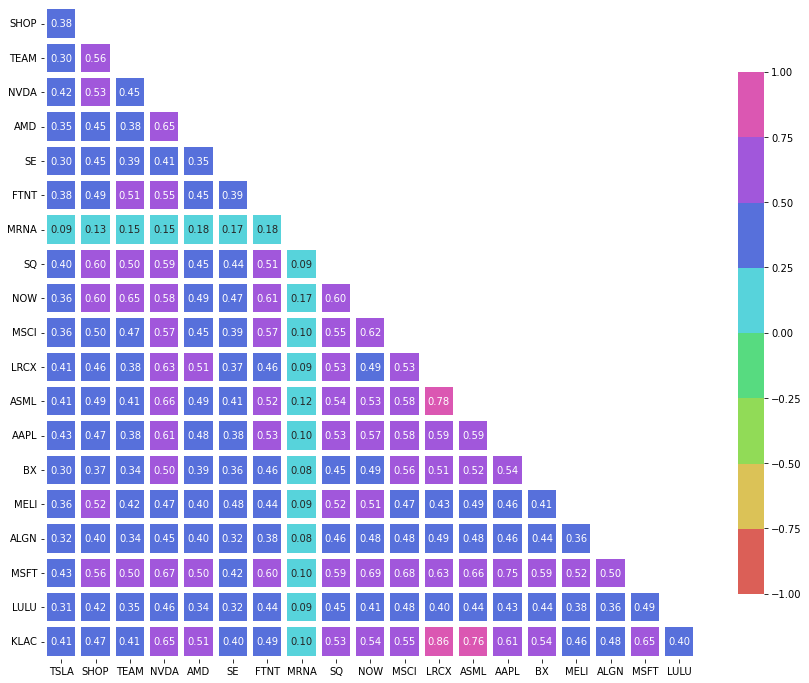

In [295]:
corr = returns.corr()

# Correlation heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 12))
mask = np.triu(np.ones_like(corr, dtype=np.bool))

mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

cmap = sns.color_palette("hls", 8)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

plt.show()

In [296]:
# Weights of each stock in the portfolio list. Will be random each time. 

num_stocks = len(port_list)
num_stocks

weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights:', weights)
print('Total Weights:', np.sum(weights))


Weights: [0.05004958 0.04995552 0.00382235 0.00635521 0.08155046 0.02681879
 0.06206185 0.07174324 0.09026853 0.00349557 0.08023771 0.07401959
 0.01733792 0.03605072 0.06024056 0.0182396  0.06026832 0.0771535
 0.04854337 0.08178757]
Total Weights: 1.0


In [297]:
np.sum(weights * returns.mean()) * 252 

#252 trading days, annualized return over 5 years of time with random weights, pecentage return based off a randomly generated portfolio.

0.39551867792478657

In [298]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))   

#linear algebra of dot product, risk percentage based off a randomly generated portfolio.

0.3094768108720543

In [299]:
#Return and Risk of 10000 Combinations

p_ret = []   #return list
p_vol = []   #volatility risk, std from mean
p_SR = []
p_wt = []     #amt of each stock we have

for x in range(10000):
  p_weights = np.random.random(num_stocks)
  p_weights /= np.sum(p_weights)

  ret_1 = np.sum(p_weights * returns.mean()) * 252
  p_ret.append(ret_1)

  vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
  p_vol.append(vol_1)

  SR_1 = (ret_1 - risk_free_rate) / vol_1
  p_SR.append(SR_1)

  p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt




(array([0.40626944, 0.39325635, 0.41304454, ..., 0.40557283, 0.38692502,
        0.41128066]),
 array([0.32442502, 0.30808386, 0.31058716, ..., 0.30599028, 0.30602812,
        0.30823722]),
 array([1.21374563, 1.23588543, 1.2896365 , ..., 1.28459255, 1.22349875,
        1.29374598]),
 array([[0.06012551, 0.07651764, 0.01360295, ..., 0.0247816 , 0.08742588,
         0.07689074],
        [0.07028955, 0.03818166, 0.07286267, ..., 0.02870125, 0.08378823,
         0.06725396],
        [0.11020499, 0.0168018 , 0.01005731, ..., 0.07844555, 0.03412983,
         0.03329927],
        ...,
        [0.07548341, 0.03420912, 0.03815333, ..., 0.02958401, 0.09428868,
         0.04430687],
        [0.02609435, 0.0250572 , 0.0077862 , ..., 0.01210333, 0.07252122,
         0.05674939],
        [0.06288421, 0.01882053, 0.078282  , ..., 0.03817183, 0.07215104,
         0.0130097 ]]))

        Return  Volatility
0     0.406269    0.324425
1     0.393256    0.308084
2     0.413045    0.310587
3     0.417192    0.322948
4     0.407202    0.308839
...        ...         ...
9995  0.407818    0.303142
9996  0.407420    0.306032
9997  0.405573    0.305990
9998  0.386925    0.306028
9999  0.411281    0.308237

[10000 rows x 2 columns]


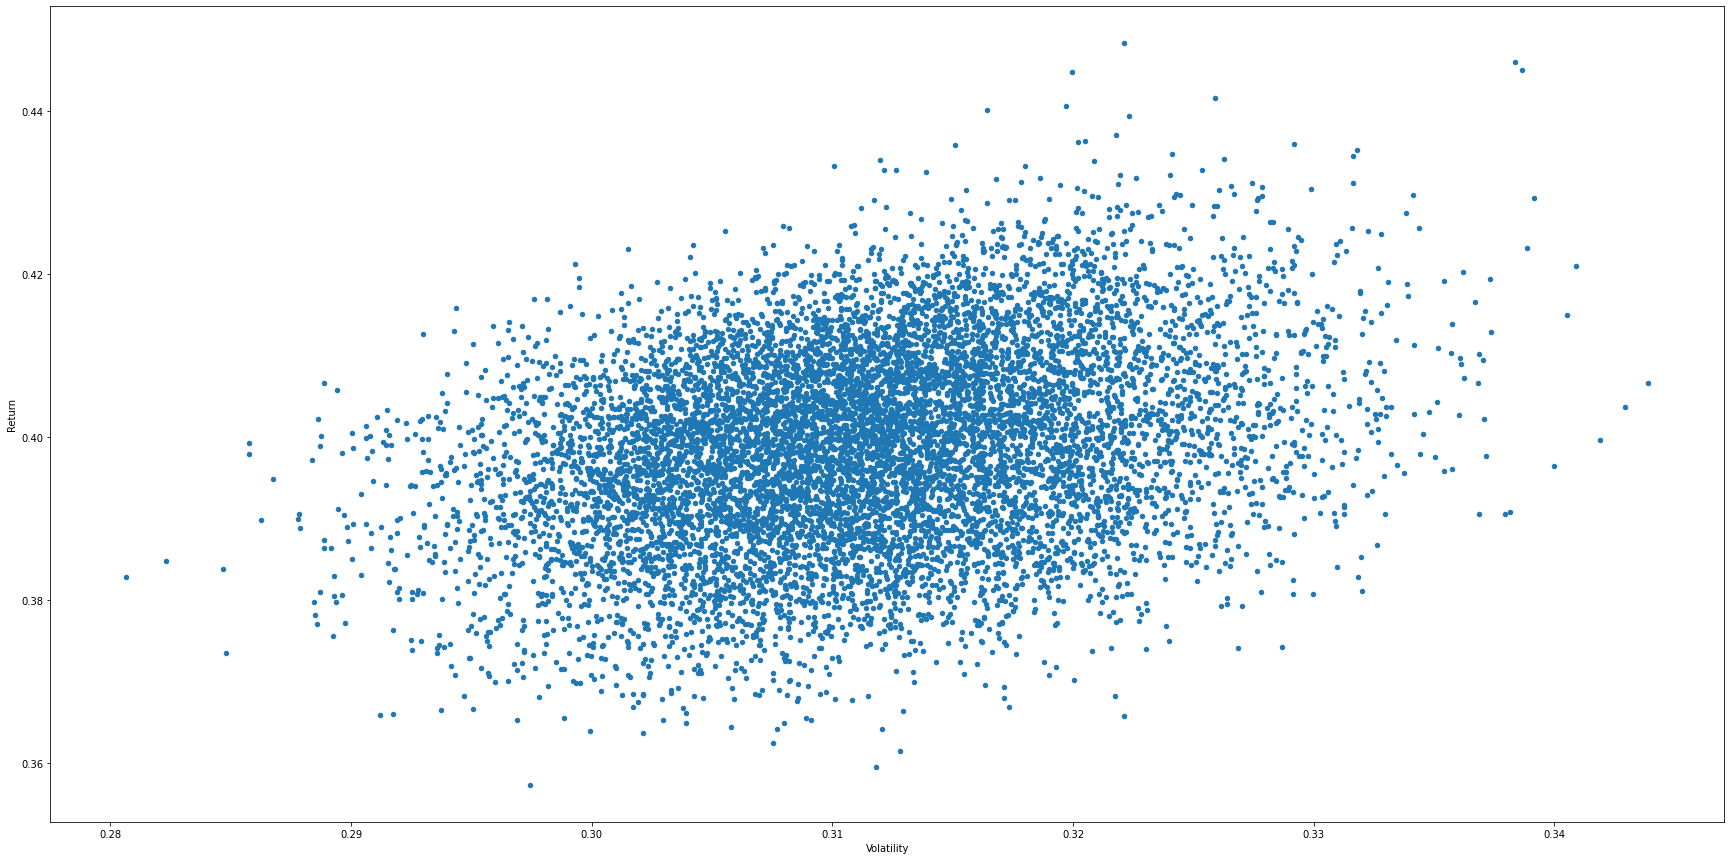

In [300]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
print(ports)
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(30,15))


In [302]:
#Sharp Ratio

SR_idx = np.argmax(p_SR)

i = 0

while i < num_stocks: 
  print('Stock : %s : %2.2f' % (port_list[i],
                                (p_wt[SR_idx][i] * 100)))
  i+=1

print('\nVolatility:', p_vol[SR_idx])
print("Return: ", p_ret[SR_idx])

Stock : TSLA : 7.69
Stock : SHOP : 2.66
Stock : TEAM : 6.75
Stock : NVDA : 5.91
Stock : AMD : 1.18
Stock : SE : 5.09
Stock : FTNT : 4.65
Stock : MRNA : 9.27
Stock : SQ : 4.26
Stock : NOW : 6.71
Stock : MSCI : 8.91
Stock : LRCX : 2.50
Stock : ASML : 0.38
Stock : AAPL : 8.95
Stock : BX : 8.25
Stock : MELI : 0.97
Stock : ALGN : 1.15
Stock : MSFT : 9.81
Stock : LULU : 2.19
Stock : KLAC : 2.71

Volatility: 0.29436646269278577
Return:  0.41587786082808836


In [303]:
def get_port_shares(one_price, force_one, wts, prices):
  num_stocks = len(wts)
  shares = []

  cost_shares = []

  i = 0
  while i < num_stocks: 
    max_price = one_price * wts[i]
    num_shares = int(max_price / prices[i])
    if(force_one & (num_shares == 0)):
      num_shares = 1
    shares.append(num_shares)
    cost = num_shares * prices[i]
    cost_shares.append(cost)
    i += 1
  return shares, cost_shares

In [304]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts


In [305]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

In [308]:
#Convert the weights to percentage

port_wts = p_wt[SR_idx].tolist()
port_wts = [i*100 for i in port_wts]

port_wts

[7.694269217929674,
 2.662337108572622,
 6.750380061222424,
 5.907825195856157,
 1.1827051113408442,
 5.092948267239993,
 4.652124318686454,
 9.266399557566903,
 4.257266213945648,
 6.709888269691963,
 8.91166381134544,
 2.4963312530800645,
 0.3817173055635286,
 8.946361910675508,
 8.254164702542761,
 0.9667717105251139,
 1.1480888161181895,
 9.811016855452358,
 2.1938460601101872,
 2.713894252534173]

In [320]:
#In the final output, we will need to find the price of the stock with the minimal weight (or weight closest to 1). This is the one_price of function get_port_shares(one_price, force_one, wts, prices)

def get_price_at_min_weight(ticker_list,weights,price):
  df = pd.DataFrame({'Ticker': ticker_list,
                   'Weights': weights,
                   'Price': price})

  min = df[df['Weights'] == df['Weights'].min()]
  min_price = min['Price']
  return(min_price)

min_price = get_price_at_min_weight(port_list, port_wts, port_prices)

In [312]:
# Getting the previous trading day and convert back to string to use in the next function.

from datetime import timedelta
from datetime import datetime
 
# Get today's date
today = datetime.today()
 
# Yesterday date
yesterday = today - timedelta(days = 1)
yesterday = yesterday.strftime('%Y-%m-%d')
type(yesterday)
yesterday

'2022-02-16'

In [321]:
# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  yesterday, 
                                  yesterday, *port_list)

# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(min_price, True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, port_list)

Shares : [5, 2, 14, 14, 6, 23, 9, 40, 25, 7, 10, 2, 1, 34, 43, 1, 1, 21, 4, 4]
Share Cost : [4616.950073242188, 1493.699951171875, 4461.939880371094, 3711.539794921875, 706.1400146484374, 3256.340042114258, 2883.2398681640625, 6072.39990234375, 2725.0, 4136.2301025390625, 5435.999755859375, 1182.93994140625, 663.8599853515625, 5866.700103759766, 5451.539947509766, 1133.8399658203125, 526.3800048828125, 6289.5, 1280.1600341796875, 1542.5999755859375]
Total Investment : 63436.99934387207
Stock Weights : [0.07278008293259823, 0.02354619491182104, 0.07033655321848245, 0.058507492997939295, 0.011131359016851883, 0.051331873761283384, 0.045450445291949006, 0.09572331549648455, 0.042956004038410295, 0.06520217137191274, 0.08569131283137346, 0.01864747629366742, 0.010464870536403933, 0.09248073150431067, 0.0859362833030402, 0.017873480422270948, 0.008297681326783312, 0.09914561005489232, 0.02018002187083821, 0.024317038818686663]


[]

#SUMMARY

In [322]:
port_df_start

,TSLA,SHOP,TEAM,NVDA,AMD,SE,FTNT,MRNA,SQ,NOW,MSCI,LRCX,ASML,AAPL,BX,MELI,ALGN,MSFT,LULU,KLAC
Date,,,,,,,,,,,,,,,,,,,,
2022-02-16,923.390015,746.849976,318.709991,265.109985,117.690002,141.580002,320.359985,151.809998,109.0,590.890015,543.599976,591.469971,663.859985,172.550003,126.779999,1133.839966,526.380005,299.5,320.040009,385.649994


In [323]:
print('Volatility:', p_vol[SR_idx]*100)
print('Return: ', p_ret[SR_idx]*100)
print('Total Share Needed: ', sum(tot_shares))
print('Total Share Cost: ', sum(share_cost))

Volatility: 29.436646269278576
Return:  41.58778608280883
Total Share Needed:  266
Total Share Cost:  63436.99934387207


In [324]:
df = pd.DataFrame({'Ticker': port_list,
                   'Weights': port_wts,
                   'Shares': tot_shares,
                   'Closing Price': port_prices,
                   'Share Cost': share_cost,
                   'Cumulative Return': top_10['CUM_RET'],
                   'Mean Return': mean_ret.tolist()})

df

,Ticker,Weights,Shares,Closing Price,Share Cost,Cumulative Return,Mean Return
5,TSLA,7.694269,5,923.390015,4616.950073,16.147766,55.679825
96,SHOP,2.662337,2,746.849976,1493.699951,10.760728,47.555807
138,TEAM,6.750380,14,318.709991,4461.939880,10.185012,46.455213
6,NVDA,5.907825,14,265.109985,3711.539795,9.263474,44.556945
72,AMD,1.182705,6,117.690002,706.140015,8.612719,43.099006
140,SE,5.092948,23,141.580002,3256.340042,8.452645,49.392911
223,FTNT,4.652124,9,320.359985,2883.239868,8.293380,42.342758
187,MRNA,9.266400,40,151.809998,6072.399902,7.875268,64.603636
171,SQ,4.257266,25,109.000000,2725.000000,7.197650,39.506447
92,NOW,6.709888,7,590.890015,4136.230103,6.124434,36.274516
